In [5]:

import heat_exchanger
from constants import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# increase figure size
plt.rcParams["figure.figsize"] = (10, 6)

In [6]:

# read GA3_previous_desgins.csv

data = pd.read_csv('GA3_previous_designs.csv')

# remove weird group C designs
df = data[~(data["year"] == 2019)]
udf = data[data["year"] == 2019] # unseen designs

df = df[~((df["year"] == 2022) & (df["group"] == "Group-C"))] # remove group C 2022
df = df[~((df["year"] == 2023) & (df["group"] == "Group-C"))] # remove group C 2023
udf


,year,group,Tube Length,Tubes,Baffles,Pattern,Side,Rotameter in1,Rotameter out1,DP_meas1,...,DP_HX1,Qdot1,Flowrate2,DP_HX2,Qdot2,Qave,Effectiveness,Qcorr,Mass,Total Length
22,2019,Group-A,0.2217,"4,4,4,4","6,6",TRIANGLE,OPPOSITE,25,25,0.385,...,0.437,11.72,0.299,0.391,12.23,11.98,0.259,12.78,1.15,NaN
23,2019,Group-B,0.2260,"7,7","11,11",TRIANGLE,SAME,22,23,0.404,...,0.458,10.40,0.462,0.219,12.04,11.22,0.207,12.82,1.03,NaN
24,2019,Group-C,0.2220,"8,8",6,TRIANGLE,OPPOSITE,35,36,0.234,...,0.275,11.51,0.462,0.212,12.04,11.77,0.186,14.23,1.09,NaN
25,2019,Group-D,0.1930,"5,5,5,5","6,6",TRIANGLE,OPPOSITE,34,35,0.320,...,0.362,14.27,0.349,0.348,13.14,13.71,0.282,16.27,1.16,NaN
26,2019,Group-E,0.2120,"9,9",8,TRIANGLE,OPPOSITE,36,37,0.286,...,0.325,15.35,0.483,0.200,14.38,14.87,0.216,17.24,1.11,NaN
27,2019,Group-E,0.2120,"9,9",8,TRIANGLE,OPPOSITE,36,37,0.283,...,0.322,15.86,0.479,0.201,14.27,15.07,0.219,17.37,1.11,NaN
28,2019,Group-D,0.1930,"5,5,5,5","6,6",TRIANGLE,OPPOSITE,34,35,0.317,...,0.359,13.80,0.354,0.348,12.60,13.20,0.267,15.62,1.16,NaN
29,2019,Group-C,0.2220,"8,8",6,TRIANGLE,OPPOSITE,35,36,0.228,...,0.269,11.26,0.476,0.199,13.38,12.32,0.187,14.76,1.09,NaN
30,2019,Group-B,0.2260,"7,7","11,11",TRIANGLE,SAME,22,23,0.395,...,0.449,10.24,0.462,0.223,12.23,11.23,0.203,12.59,1.03,NaN
31,2019,Group-A,0.2217,"4,4,4,4","6,6",TRIANGLE,OPPOSITE,25,25,0.370,...,0.422,10.34,0.299,0.400,11.12,10.73,0.252,12.44,1.15,NaN


In [7]:

HX = heat_exchanger.build_heat_exchanger([2],[2], 0.31, Side.OPPOSITE, Pattern.SQUARE)
HX.set_conditions([20, 60])


In [8]:
def comptute_designs(df):
    mdot_colds = np.zeros(len(df))
    mdot_hots = np.zeros(len(df))
    Qdots = np.zeros(len(df))
    effs = np.zeros(len(df))

    hot_passes = np.zeros(len(df))
    cold_passes = np.zeros(len(df))

    for i, row in enumerate(df.iterrows()):
        
        tubes = str(row[1]["Tubes"]).split(",")
        tubes = [int(t) for t in tubes]
        baffles = str(row[1]["Baffles"]).split(",")
        baffles = [int(b) for b in baffles]
        length = float(row[1]["Tube Length"])

        hot_passes[i] = len(tubes)
        cold_passes[i] = len(baffles)

        pattern_str = row[1]["Pattern"]
        if pattern_str == "SQUARE":
            pattern = Pattern.SQUARE
        elif pattern_str == "TRIANGLE":
            pattern = Pattern.TRIANGLE
        
        HX = heat_exchanger.build_heat_exchanger(tubes, baffles, length, Side.OPPOSITE, pattern)
        HX.set_conditions([20, 60])
        HX.characteristic_year = row[1]["year"]

        result = HX.compute_effectiveness(method = "LMTD", optimiser="fsolve")

        if not result:
            continue

        Qdots[i] = HX.Qdot
        effs[i] = HX.effectiveness
        mdot_colds[i] = HX.mdot[0]
        mdot_hots[i] = HX.mdot[1]
    
    return Qdots, effs, mdot_colds, mdot_hots, hot_passes, cold_passes

Qdots, effs, mdot_colds, mdot_hots, hot_passes, cold_passes = comptute_designs(df)
uQdots, ueffs, umdot_colds, umdot_hots, u_hot_passes, u_cold_passes = comptute_designs(udf) # unseen designs

[   1.01022751 -456.07612394]


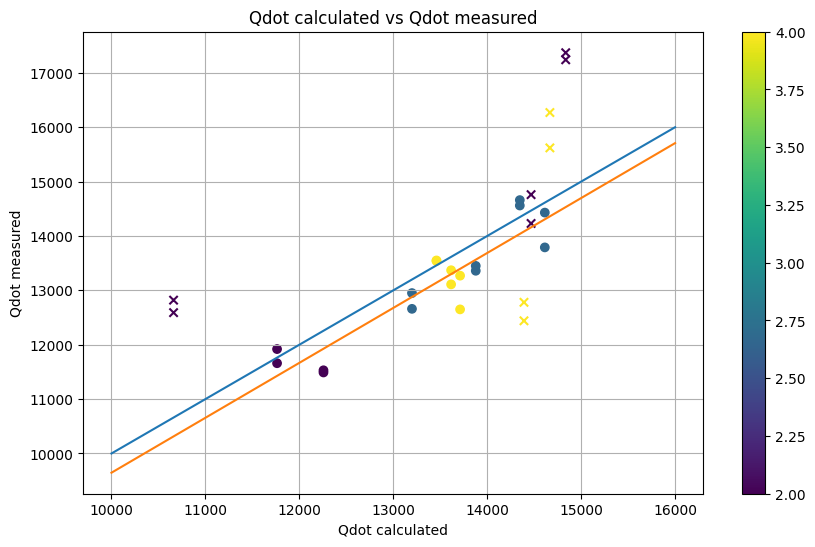

In [9]:
# plot Qdot calculated vs Qdot measured

lin = np.linspace(1e4, 1.6e4, 100)

plt.figure()
plt.scatter(Qdots, 1e3*df["Qcorr"], c=hot_passes, marker="o")
plt.scatter(uQdots, 1e3*udf["Qcorr"], c=u_hot_passes, marker="x")
plt.plot(lin, lin)
# colorbar
plt.colorbar()

qdot_fit = np.polyfit(Qdots, 1e3*df["Qcorr"], 1)
qdot_fit_fn = np.poly1d(qdot_fit)
print(qdot_fit)
plt.plot(lin, qdot_fit_fn(lin), label=f"y = {qdot_fit[0]:.2f}x + {qdot_fit[1]:.2f}")

plt.xlabel("Qdot calculated")
plt.ylabel("Qdot measured")
plt.title("Qdot calculated vs Qdot measured")
plt.grid()

# Doesnt look terrible

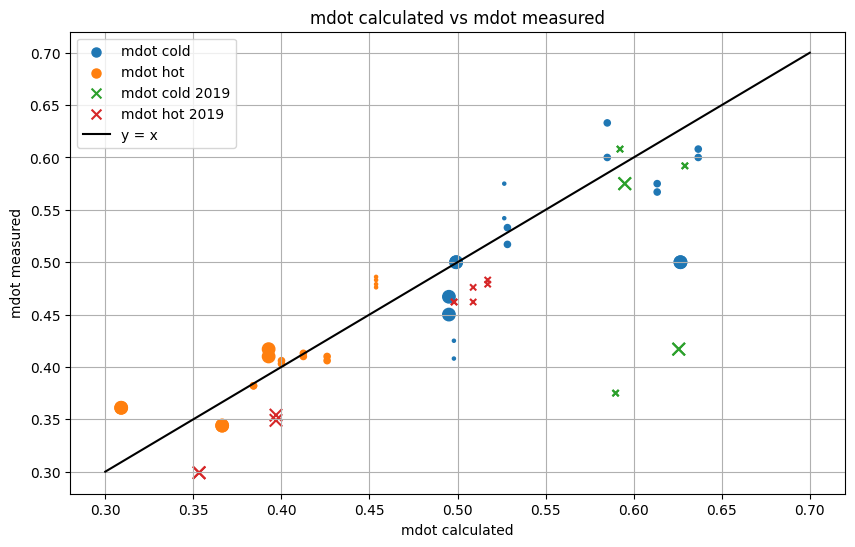

In [10]:
# plot mdot cold and mdot hot
lin = np.linspace(0.3, 0.7, 100)

plt.figure()
plt.scatter(mdot_colds, df["Flowrate1"], s=5 * hot_passes ** 2, label="mdot cold")
plt.scatter(mdot_hots, df["Flowrate2"],  s=5 * hot_passes ** 2, label="mdot hot")
plt.scatter(umdot_colds, udf["Flowrate1"], s=5 * u_hot_passes ** 2, label="mdot cold 2019", marker="x")
plt.scatter(umdot_hots, udf["Flowrate2"], s=5 * u_hot_passes ** 2, label="mdot hot 2019", marker="x")
plt.plot(lin, lin, color = "black", label="y = x")

plt.xlabel("mdot calculated")
plt.ylabel("mdot measured")
plt.title("mdot calculated vs mdot measured")
plt.grid()
plt.legend()

# looks terrible need to fix

[ 9.31806394e-01 -1.00644936e+03]


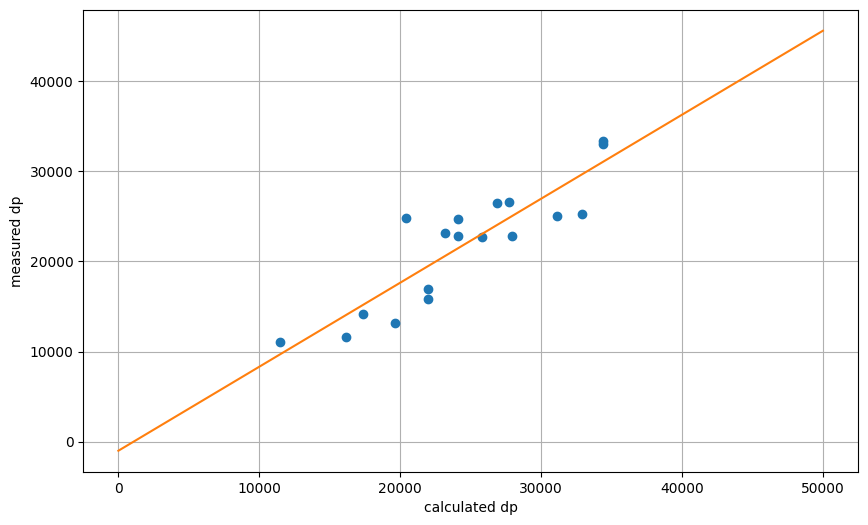

In [21]:
from heat_exchanger import dp_from_cold_mass_flow
# plot cold dp vs measured dp at measured mass flow

measured_cold_mdot = df["Flowrate1"]
measured_cold_dp = df[" DP_meas1"] * 1e5

calc_cold_dp = np.zeros(len(df))

for i, row in enumerate(df.iterrows()):
    calc_cold_dp[i] = dp_from_cold_mass_flow(row[1]["Flowrate1"], row[1]["year"])

linearfit = np.polyfit(calc_cold_dp, measured_cold_dp, 1)
linearfit_fn = np.poly1d(linearfit)
print(linearfit)

x = np.linspace(0, 5e4, 100)

plt.figure()
plt.plot(calc_cold_dp, measured_cold_dp, 'o')
plt.plot(x, linearfit_fn(x))
plt.xlabel("calculated dp")
plt.ylabel("measured dp")

plt.grid()
plt.show()


# same thing for hot

from heat_exchanger import hot_mass_flow_from_dp



mdot_hot_calc = np.zeros(len(df))
for i,row in enumerate(df.iterrows()):
    mdot_hot_calc[i] = hot_mass_flow_from_dp( * 1e5, row[1]["year"])




[ 1.18073779e+00 -5.91294176e+03]


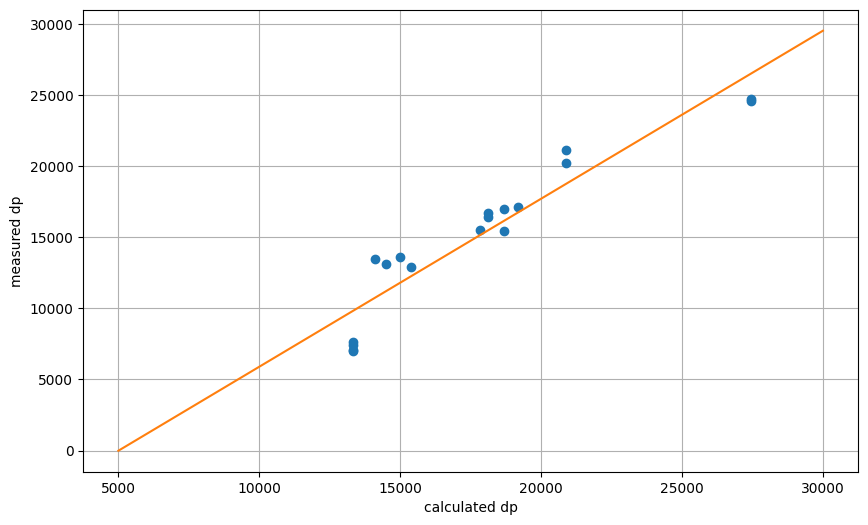

In [24]:
from heat_exchanger import dp_from_hot_mass_flow

measured_dp_hot = df["  DP_meas2"] * 1e5
calc_dp_hot = np.zeros(len(df))

for i, row in enumerate(df.iterrows()):
    calc_dp_hot[i] = dp_from_hot_mass_flow(row[1]["Flowrate2"], row[1]["year"])

linearfit = np.polyfit(calc_dp_hot, measured_dp_hot, 1)
linearfit_fn = np.poly1d(linearfit)
print(linearfit)

x = np.linspace(5e3, 3e4, 100)

plt.figure()
plt.plot(calc_dp_hot, measured_dp_hot, 'o')
plt.plot(x, linearfit_fn(x))
plt.xlabel("calculated dp")
plt.ylabel("measured dp")

plt.grid()

In [13]:
dp_colds = np.zeros(len(df))
dp_hots = np.zeros(len(df))
Qdots = np.zeros(len(df))
effs = np.zeros(len(df))

hot_passes = np.zeros(len(df))
cold_passes = np.zeros(len(df))

for i, row in enumerate(df.iterrows()):
    
    tubes = str(row[1]["Tubes"]).split(",")
    tubes = [int(t) for t in tubes]
    baffles = str(row[1]["Baffles"]).split(",")
    baffles = [int(b) for b in baffles]
    length = float(row[1]["Tube Length"])

    hot_passes[i] = len(tubes)
    cold_passes[i] = len(baffles)

    pattern_str = row[1]["Pattern"]
    if pattern_str == "SQUARE":
        pattern = Pattern.SQUARE
    elif pattern_str == "TRIANGLE":
        pattern = Pattern.TRIANGLE
    
    HX = heat_exchanger.build_heat_exchanger(tubes, baffles, length, Side.OPPOSITE, pattern)
    HX.set_conditions([20, 60])
    HX.characteristic_year = row[1]["year"]

    result = HX.compute_effectiveness(method = "LMTD", optimiser="fsolve")

    if not result:
        continue

    Qdots[i] = HX.Qdot
    effs[i] = HX.effectiveness
    dp_colds[i], dp_hots[i] = HX.calc_dp(HX.mdot)

[  0.86279134 121.77888182]
[ 1.62218865e+00 -1.28631797e+04]


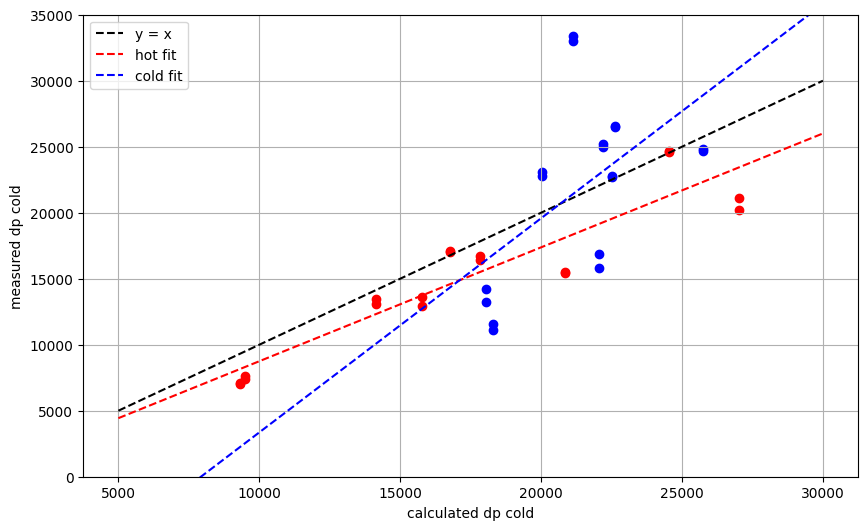

In [25]:

# plot

plt.figure()
plt.scatter(dp_colds, measured_cold_dp, c='blue')
plt.scatter(dp_hots, measured_dp_hot, c='red')

hot_lin_fit = np.polyfit(dp_hots, measured_dp_hot, 1)
hot_lin_fit_f  = np.poly1d(hot_lin_fit)
cold_lin_fit = np.polyfit(dp_colds, measured_cold_dp, 1)
cold_lin_fit_f = np.poly1d(cold_lin_fit)

print(hot_lin_fit)
print(cold_lin_fit)

x = np.linspace(5e3, 3e4, 100)

plt.plot(x, x, 'k--', label = "y = x")
plt.plot(x, hot_lin_fit_f(x), 'r--', label = "hot fit")
plt.plot(x, cold_lin_fit_f(x), 'b--', label = "cold fit")
plt.xlabel("calculated dp cold")
plt.ylabel("measured dp cold")

plt.ylim(0, 3.5e4)
plt.grid()
plt.legend()
plt.savefig("dp_calc_vs_meas.png")

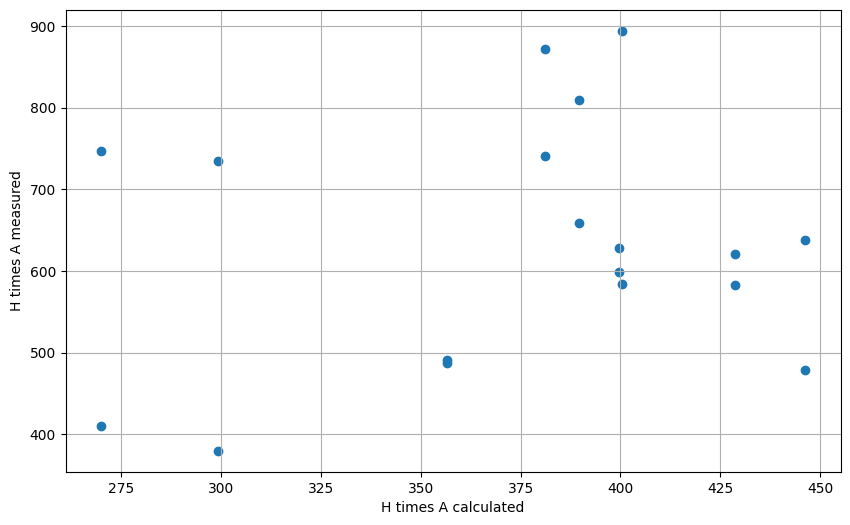

In [15]:
from heat_exchanger import logmeanT

dhas = np.zeros(len(df))

Qdots = np.zeros(len(df))
effs = np.zeros(len(df))

hot_passes = np.zeros(len(df))
cold_passes = np.zeros(len(df))

for i, row in enumerate(df.iterrows()):
    
    tubes = str(row[1]["Tubes"]).split(",")
    tubes = [int(t) for t in tubes]
    baffles = str(row[1]["Baffles"]).split(",")
    baffles = [int(b) for b in baffles]
    length = float(row[1]["Tube Length"])

    hot_passes[i] = len(tubes)
    cold_passes[i] = len(baffles)

    pattern_str = row[1]["Pattern"]
    if pattern_str == "SQUARE":
        pattern = Pattern.SQUARE
    elif pattern_str == "TRIANGLE":
        pattern = Pattern.TRIANGLE
    
    HX = heat_exchanger.build_heat_exchanger(tubes, baffles, length, Side.OPPOSITE, pattern)
    HX.set_conditions([20, 60])
    HX.characteristic_year = row[1]["year"]

    result = HX.compute_effectiveness(method = "LMTD", optimiser="fsolve")

    if not result:
        continue

    Qdots[i] = HX.Qdot
    effs[i] = HX.effectiveness
    dhas[i] = HX.calc_area_times_H(HX.mdot)


plt.figure()

lgmt = logmeanT(df[" Tcold_in"], df[" Tcold_out"], df[" Thot_in"], df[" Thot_out"])
dhs_exp = 1e3 * df["Qcorr"] / lgmt

plt.scatter(dhas, dhs_exp)
plt.xlabel("H times A calculated")
plt.ylabel("H times A measured")

plt.grid()
plt.show()

In [16]:
from heat_exchanger import pitch_from_tubes

print(pitch_from_tubes(5, 3, Pattern.TRIANGLE))

0.014493144893777099
